In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = [x for x in os.listdir("namesbystate") if 'pdf' not in x and x != '.DS_Store' ]
newlist = []
columns = ['state','sex','year','name','births']
for file in files:
    path = 'namesbystate/{}'.format(file)
    df = pd.read_csv(path,names=columns)
    newlist.append(df)
names = pd.concat(newlist,ignore_index = True)
states_list = [file[:2] for file in files]

In [3]:
us_states = {
 'AK': 'Alaska',
 'AL': 'Alabama',
 'AR': 'Arkansas',
 'AZ': 'Arizona',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'District of Columbia',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'IA': 'Iowa',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Massachusetts',
 'MD': 'Maryland',
 'ME': 'Maine',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Missouri',
 'MS': 'Mississippi',
 'MT': 'Montana',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'NE': 'Nebraska',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NV': 'Nevada',
 'NY': 'New York',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'VT': 'Vermont',
 'WA': 'Washington',
 'WI': 'Wisconsin',
 'WV': 'West Virginia',
 'WY': 'Wyoming'
}
len(us_states)

51

## Final

In [9]:
class BabyNames(object):
    def __init__(self, fileloc):
        self.fileloc = fileloc
        
        files = [x for x in os.listdir(self.fileloc) if 'pdf' not in x and x != '.DS_Store']
        newlist = []
        columns = ['state','sex','year','name','births']
        for file in files:
            path = '{}/{}'.format(self.fileloc, file)
            df = pd.read_csv(path,names=columns)
            newlist.append(df)
        self.data = pd.concat(newlist,ignore_index = True)
        
        self.states_list = [file[:2] for file in files]
        self.years_list = self.data.year.unique()
     
    
    def Count(self, state='', year=''):
        state = self.states_list if state == '' else [state]
        year = self.years_list if year == '' else [year]
        return self.data[(self.data["state"].isin(state)) & 
                  (self.data["year"].isin(year))]["births"].sum()
    

    def Top10BabyNames(self, state='', year=''):
        def get_top10(group):
            return group.sort_values(by='births',ascending=False).head(10)
        
        state = self.states_list if state == '' else [state]
        year = self.years_list if year == '' else [year]
        df = self.data[self.data["state"].isin(state) & 
                self.data["year"].isin(year)][["name", "births", "sex"]
                                             ].groupby(["name", "sex"], as_index = False
                                                      ).sum().groupby("sex", as_index = False
                                                                     ).apply(get_top10)[["name","sex"]]
        df["Rank"] = list(range(1,11))*2
        df = df.pivot(index = "Rank", columns = "sex", values = "name").reset_index()
        result = pd.DataFrame({"Rank" : df.Rank, "Male" : df.M, "Female" : df.F})[["Rank", "Male", "Female"]]
        return result
    
    
    def ChangeOfPopularity(self, fromYear=2014, toYear=2015, top=10):
        def add_prop(group):
            group['prop'] = round(100.0*group.births / group.births.sum(), 4)
            return group
        
        def get_top(group):
            return group.sort_values(by=toYear,ascending=False).head(top)
        
        df = self.data[(names["year"] == fromYear) | (names["year"] == toYear)
                      ].groupby(["name", "year"], as_index = False).sum().groupby("year", 
                                                                                  as_index = False).apply(add_prop)
        df = df.pivot(index = "name", columns = "year", values = "prop").fillna(0).reset_index()

        df["delta"] = df[toYear] - df[fromYear]
        df["sign"] = "neg" 
        df.loc[(df.delta>0),"sign"] = "pos"
        df.loc[(df.delta==0),"sign"] = "zero"
        df = df.groupby("sign").apply(get_top)[["sign", "name", toYear]].reset_index(drop = True)
        df["Rank"] = list(range(1,top+1))*3

        df = df.pivot(index = "Rank", columns="sign", values = "name")
        result = pd.DataFrame({"c1" : df.pos, "c2" : df.neg, "c3" : df.zero}
                             ).rename(columns={"c1": "More popular", "c2" : "Less popular", "c3" : "Same popularity"})
        return result
    
    
    def Top5NamesPerYear(self,year=2015,sex=''):
        sex = ["M", "F"] if sex == '' else [sex]
        year = self.years_list if year == '' else [year]
        
        cols = ["State"]
        for x in range(1,6):
            cols.append("Rank {}".format(x))
            cols.append("Num")
        top5df = pd.DataFrame(columns=cols, index=range(51))

        for i in range(len(self.states_list)):
            df = self.data[(self.data["year"].isin(year)) & (names["sex"].isin(sex)) & 
                          (names["state"]==self.states_list[i])
                          ].sort_values(by="births", ascending = False).head(5).reset_index(drop = True)
            #df.index = range(5)

            top5df.iloc[i,0] = us_states[self.states_list[i]]
            for x in range(5):
                top5df.iloc[i,x*2+1] = df.iloc[x,3]
                top5df.iloc[i,x*2+2] = df.iloc[x,4]
        return top5df

    
    def NamePopularityPlot(self, name='Jim', yearRange=(2000,2015), state='IL', sex='M'):
        def add_prop(group):
            group['prop'] = 100.0*group.births / group.births.sum()
            return group
    
        df = self.data[self.data["state"] == state].groupby(['year','sex']).apply(add_prop)
        df = df[(df["year"]>=yearRange[0]) & (df["year"]<=yearRange[1])
                & (df["sex"] == sex) & (df["name"] == name)]
        t = "Popularity of name {} from {} to {}".format(name, yearRange[0], yearRange[1])
        df.set_index("year")["prop"].plot(title=t,figsize=(12,6))

        
    def NameFlip(self, n=10):
        dfy = self.data.groupby(['name', 'year', 'sex'], as_index = False).sum().pivot_table(values = "births", columns = "sex", index = ["name", "year"]).fillna(0).reset_index()
        dfy["delta"] = dfy.F - dfy.M
        dfy["tot"] = dfy.F + dfy.M

        df = dfy[['name', 'delta', 'tot']].groupby("name").agg(["max", "min", "sum"]).reset_index()
        df["check"] = 0
        df.loc[(df["delta", "max"] > 0) & (df["delta", "min"] < 0), "check"] = 1

        result = pd.merge(pd.DataFrame(df[df.check == 1].sort_values([("tot", "sum")], ascending = False).head(n)["name"]),
                          dfy[["name", "year", "delta"]], left_on='name', right_on='name' , how='inner', sort=False)

        result = result.pivot(index = "year", columns = "name", values = "delta").fillna(0)
        t = "Top {} names that flipped over the years".format(n)
        result.plot(title=t,figsize=(12,6))
    
    
s1 = BabyNames('namesbystate')

In [10]:
s1.Count(state="", year="")

305154531

In [11]:
s1.Top10BabyNames(year = [1991, 1992], state = "MI")

,Rank,Male,Female
0,1,Michael,Ashley
1,2,Joshua,Jessica
2,3,Matthew,Samantha
3,4,Christopher,Amanda
4,5,Jacob,Sarah
5,6,Andrew,Brittany
6,7,Tyler,Emily
7,8,Nicholas,Chelsea
8,9,Brandon,Megan
9,10,Ryan,Rachel


In [12]:
s1.ChangeOfPopularity(fromYear = 2013, toYear = 2016, top = 6)

,More popular,Less popular,Same popularity
Rank,,,
1,Olivia,Emma,Melanie
2,Noah,Liam,Deacon
3,Ava,Sophia,Niko
4,James,William,Jaylene
5,Benjamin,Mason,Carolyn
6,Mia,Isabella,Abrielle


In [13]:
s1.Top5NamesPerYear(year = 1991, sex = "F").sample(4)

,State,Rank 1,Num,Rank 2,Num,Rank 3,Num,Rank 4,Num,Rank 5,Num
0,Alaska,Jessica,106,Ashley,102,Amanda,85,Sarah,78,Samantha,71
38,Pennsylvania,Ashley,1958,Jessica,1673,Amanda,1502,Brittany,1432,Samantha,1389
31,New Jersey,Jessica,1232,Ashley,1116,Amanda,959,Samantha,930,Stephanie,914
29,Nebraska,Jessica,255,Ashley,253,Amanda,208,Sarah,181,Emily,179


/Users/luca/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2002.0, right=2002.0
  'left=%s, right=%s') % (left, right))


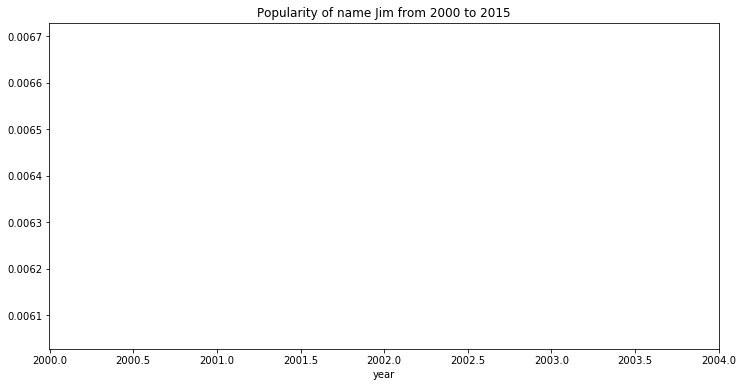

In [16]:
s1.NamePopularityPlot()

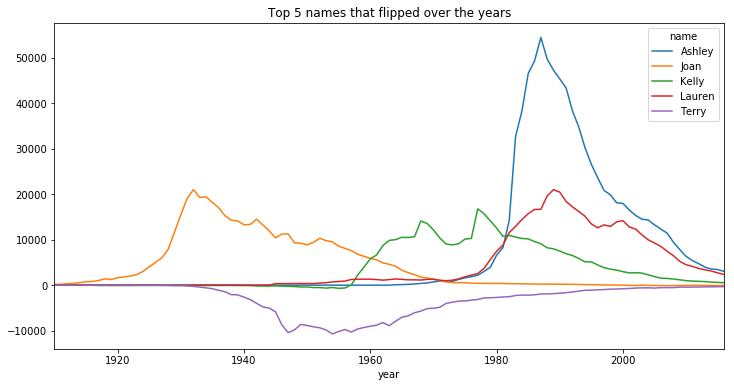

In [15]:
s1.NameFlip(5)

# Crap tests

In [4]:
year = [1991]
mystate = ["MI"]
sex = ["F"]
len(states_list)

51

In [125]:
#TOP 10 BABY NAMES
def get_top10(group):
    return group.sort_values(by='births',ascending=False).head(10)

df = names[names["state"].isin(state) & 
     names["year"].isin(year)][["name", "births", "sex"]].groupby(["name", "sex"], as_index = False).sum().groupby("sex", as_index = False).apply(get_top10)[["name","sex"]]
df["Rank"] = list(range(1,11))*2
df = df.pivot(index = "Rank", columns = "sex", values = "name").rename(columns={'F': 'Female', 'M' : 'Male'}).reset_index()
result = pd.DataFrame({"Rank" : df.Rank, "Male" : df.Male, "Female" : df.Female})[["Rank", "Male", "Female"]]


In [310]:
#DELTA IN POPULARITY
fromYear=2013
toYear=2016
top=10

def get_top(group):
    return group.sort_values(by=toYear,ascending=False).head(top)

def add_prop(group):
    group['prop'] = round(100.0*group.births / group.births.sum(), 4)
    return group

df = names[(names["year"] == fromYear) | (names["year"] == toYear)].groupby(["name", "year"], as_index = False).sum().groupby("year", as_index = False).apply(add_prop)
df = df.pivot(index = "name", columns = "year", values = "prop").fillna(0).reset_index()

df["delta"] = df[toYear] - df[fromYear]
df["sign"] = "neg" 
df.loc[(df.delta>0),"sign"] = "pos"
df.loc[(df.delta==0),"sign"] = "zero"
df = df.groupby("sign").apply(get_top)[["sign", "name", toYear]].reset_index(drop = True)
df["Rank"] = list(range(1,top+1))*3

df = df.pivot(index = "Rank", columns="sign", values = "name")
result = pd.DataFrame({"c1" : df.pos, "c2" : df.neg, "c3" : df.zero}).rename(columns={"c1": "More popular", "c2" : "Less popular", "c3" : "Same popularity"}).head(10)



In [184]:
#TOP 5 NAMES PER YEAR PER STATE

cols = ["State"]
for x in range(1,6):
    cols.append("Rank {}".format(x))
    cols.append("Num")
top5df = pd.DataFrame(columns=cols, index=range(51))

for i in range(len(states_list)):
    df = names[(names["year"].isin(year)) & (names["sex"].isin(sex)) & 
                  (names["state"]==states_list[i])].sort_values(by="births", ascending = False).head(5)
    df.index = range(5)

    top5df.iloc[i,0] = states_list[i]
    for x in range(5):
        top5df.iloc[i,x*2+1] = df.iloc[x,3]
        top5df.iloc[i,x*2+2] = df.iloc[x,4]

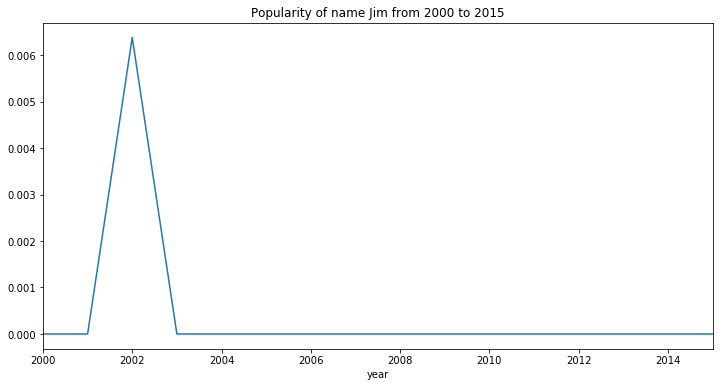

In [34]:
### TEST

name='Jim'
yearRange=(2000,2015)
state='IL'
sex='M'

idx = pd.DataFrame({"year" : [yearRange[0] + i for i in range(yearRange[1]-yearRange[0]+1)]})

def add_prop(group):
    group['prop'] = 100.0*group.births / group.births.sum()
    return group

df = names[names["state"] == state].groupby(['year','sex']).apply(add_prop)
df = df[(df["year"]>=yearRange[0]) & (df["year"]<=yearRange[1])
        & (df["sex"] == sex) & (df["name"] == name)][["prop", "year"]]

idx = idx.merge(df, how="left", on="year").fillna(0)

t = "Popularity of name {} from {} to {}".format(name, yearRange[0], yearRange[1])
idx.set_index("year")["prop"].plot(title=t,figsize=(12,6))

In [33]:
#PLOT POPULARITY OVER TIME

name='James'
yearRange=(2000,2015)
state='IL'
sex='M'

def add_prop(group):
    group['prop'] = 100.0*group.births / group.births.sum()
    return group

df = names[names["state"] == state].groupby(['year','sex']).apply(add_prop)
df = df[(df["year"]>=yearRange[0]) & (df["year"]<=yearRange[1])
        & (df["sex"] == sex) & (df["name"] == name)]

t = "Popularity of name {} from {} to {}".format(name, yearRange[0], yearRange[1])
df
#df.set_index("year")["prop"].plot(title=t,figsize=(12,6))

,state,sex,year,name,births,prop
1775702,IL,M,2002,Jim,5,0.006378


In [27]:
#FLIPPING NAMES
n = 10

dfy = names.groupby(['name', 'year', 'sex'], as_index = False).sum().pivot_table(values = "births", columns = "sex", index = ["name", "year"]).fillna(0).reset_index()
dfy["delta"] = dfy.F - dfy.M
dfy["tot"] = dfy.F + dfy.M

df = dfy[['name', 'delta', 'tot']].groupby("name").agg(["max", "min", "sum"]).reset_index()
df["check"] = 0
df.loc[(df["delta", "max"] > 0) & (df["delta", "min"] < 0), "check"] = 1

result = pd.merge(pd.DataFrame(df[df.check == 1].sort_values([("tot", "sum")], ascending = False).head(n)["name"]),
                  dfy[["name", "year", "delta"]], left_on='name', right_on='name' , how='inner', sort=False)

result = result.pivot(index = "year", columns = "name", values = "delta").fillna(0)
t = "Top {} names that flipped over the years".format(n)
#result.plot(title=t,figsize=(12,6))
